In [29]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed-without-outliers.csv"
d = pd.read_csv(datafilename)
print("Loading", len(d), "lines of data (outliers removed).")

resultsfilename = "data_stats-without-outliers.csv"
st = pd.read_csv(resultsfilename)
print("Loading", len(st), "lines of stats.")

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]
                                 ), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

Loading 14398 lines of data (outliers removed).
Loading 800 lines of stats.


In [30]:
# comparison by design expertise

types = ["lexical", "recognition"]
fonts = ["arial", "sansforgetica"]
skills = ["Designer", "Non-designer"]
metrics = ["Response time", "Response time (word)", "Response time (non-word)", "AUC", "AUC (word)", "AUC (non-word)"]
RTs = metrics[:3]
AUCs = metrics[3:]

cols = pd.MultiIndex.from_product([skills, metrics, ["mean", "SEM"]], names=["skill", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for skill in skills:
        if skill == "Designer":
            r = st[st["isDesigner"] & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        else:
            r = st[(st["isDesigner"] == False) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (skill, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (skill, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-design-expertise.csv")

skill                              Designer                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2558.58  138.385              1678.88   
                sansforgetica       3035.93  322.033              1989.18   
    recognition arial               2454.94  115.525              2297.41   
                sansforgetica        2588.1  120.122              2408.27   
2   lexical     arial               2623.96  154.483              1932.14   
                sansforgetica       3152.06  202.938              2120.86   
    recognition arial               2579.49  106.879              2370.69   
                sansforgetica       2680.21  103.498              2384.59   

skill                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          52.1944                  3438.77  249.832   
                sansforgetica  108.527                  4082.68  581.793   
    recognition arial           104.78                  2612.47  153.811   
                sansforgetica  107.694                  2767.94  159.232   
2   lexical     arial          122.879                  3315.78  253.783   
                sansforgetica  105.539                  4183.26   331.49   
    recognition arial          97.4546                   2788.3  150.051   
                sansforgetica  97.7479                   2975.6  156.381   

skill                                                                      \
metric                              AUC             AUC (word)              
stat                               mean         SEM       mean        SEM   
sid type        font                                                        
1   lexical     arial          0.971583   0.0065398        NaN        NaN   
                sansforgetica  0.979434  0.00528001        NaN        NaN   
    recognition arial          0.896521   0.0146142   0.880307   0.018187   
                sansforgetica  0.890478   0.0161991   0.870283  0.0213533   
2   lexical     arial          0.947281   0.0126229        NaN        NaN   
                sansforgetica  0.932368   0.0150563        NaN        NaN   
    recognition arial          0.840598   0.0173912   0.850329  0.0220519   
                sansforgetica   0.84937    0.017666   0.868421  0.0197694   

skill                            ...             Non-designer           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                  2154.98  130.863   
                sansforgetica    ...                  2378.54  154.536   
    recognition arial            ...                  2815.68  152.576   
                sansforgetica    ...                  2679.59  113.896   
2   lexical     arial            ...                  1934.92  100.845   
                sansforgetica    ...                  2095.47  85.8405   
    recognition arial            ...                  2475.98  96.0664   
                sansforgetica    ...                  2672.86  108.273   

skill                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                   

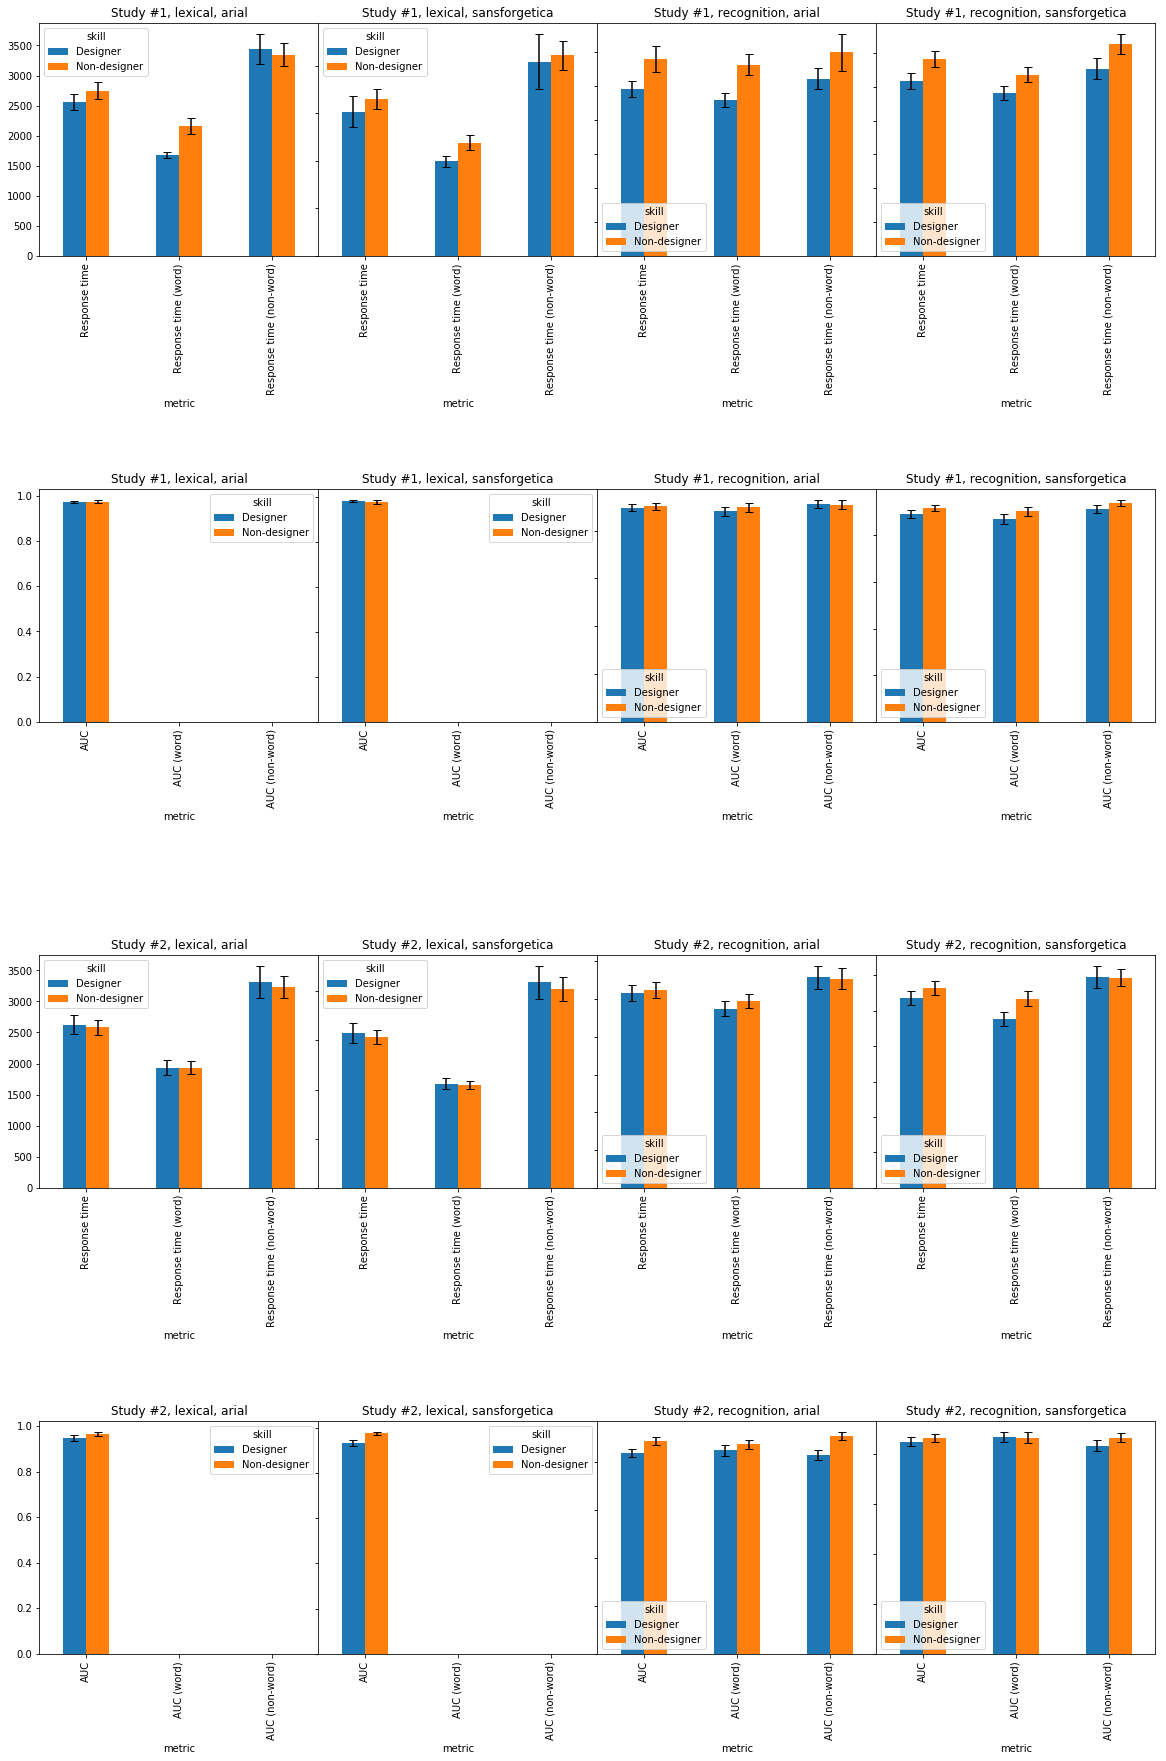

In [31]:
# comparison by design expertise - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-design-expertise.pdf")

In [32]:
# comparison by order

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order.csv")

order                                     1                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2645.38  100.451              1894.84   
                sansforgetica       3154.48  198.613               2165.8   
    recognition arial                   NaN      NaN                  NaN   
                sansforgetica           NaN      NaN                  NaN   
2   lexical     arial               2695.33  153.916              2054.67   
                sansforgetica       3238.31   158.86              2120.38   
    recognition arial               2601.21  118.288              2430.27   
                sansforgetica        2558.9  77.3495              2364.02   

order                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          69.7922                  3396.18  160.818   
                sansforgetica  93.4315                  4143.17  346.279   
    recognition arial              NaN                      NaN      NaN   
                sansforgetica      NaN                      NaN      NaN   
2   lexical     arial          132.482                  3335.98  259.236   
                sansforgetica  93.6438                  4356.24  240.987   
    recognition arial          105.474                  2772.15  168.327   
                sansforgetica  97.2278                  2753.52   95.897   

order                                                                      \
metric                              AUC             AUC (word)              
stat                               mean         SEM       mean        SEM   
sid type        font                                                        
1   lexical     arial          0.972308  0.00480435        NaN        NaN   
                sansforgetica  0.977423  0.00457382        NaN        NaN   
    recognition arial               NaN         NaN        NaN        NaN   
                sansforgetica       NaN         NaN        NaN        NaN   
2   lexical     arial           0.94949   0.0145118        NaN        NaN   
                sansforgetica  0.956667  0.00893724        NaN        NaN   
    recognition arial          0.847895   0.0167381   0.848852  0.0213779   
                sansforgetica  0.825666   0.0166221   0.828125   0.020214   

order                            ...                        2           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                      NaN      NaN   
                sansforgetica    ...                      NaN      NaN   
    recognition arial            ...                   2532.5  93.1272   
                sansforgetica    ...                  2531.34  79.1093   
2   lexical     arial            ...                  1823.32  96.3935   
                sansforgetica    ...                  2097.55  104.557   
    recognition arial            ...                  2406.31   90.656   
                sansforgetica    ...                  2677.87  107.727   

order                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                   

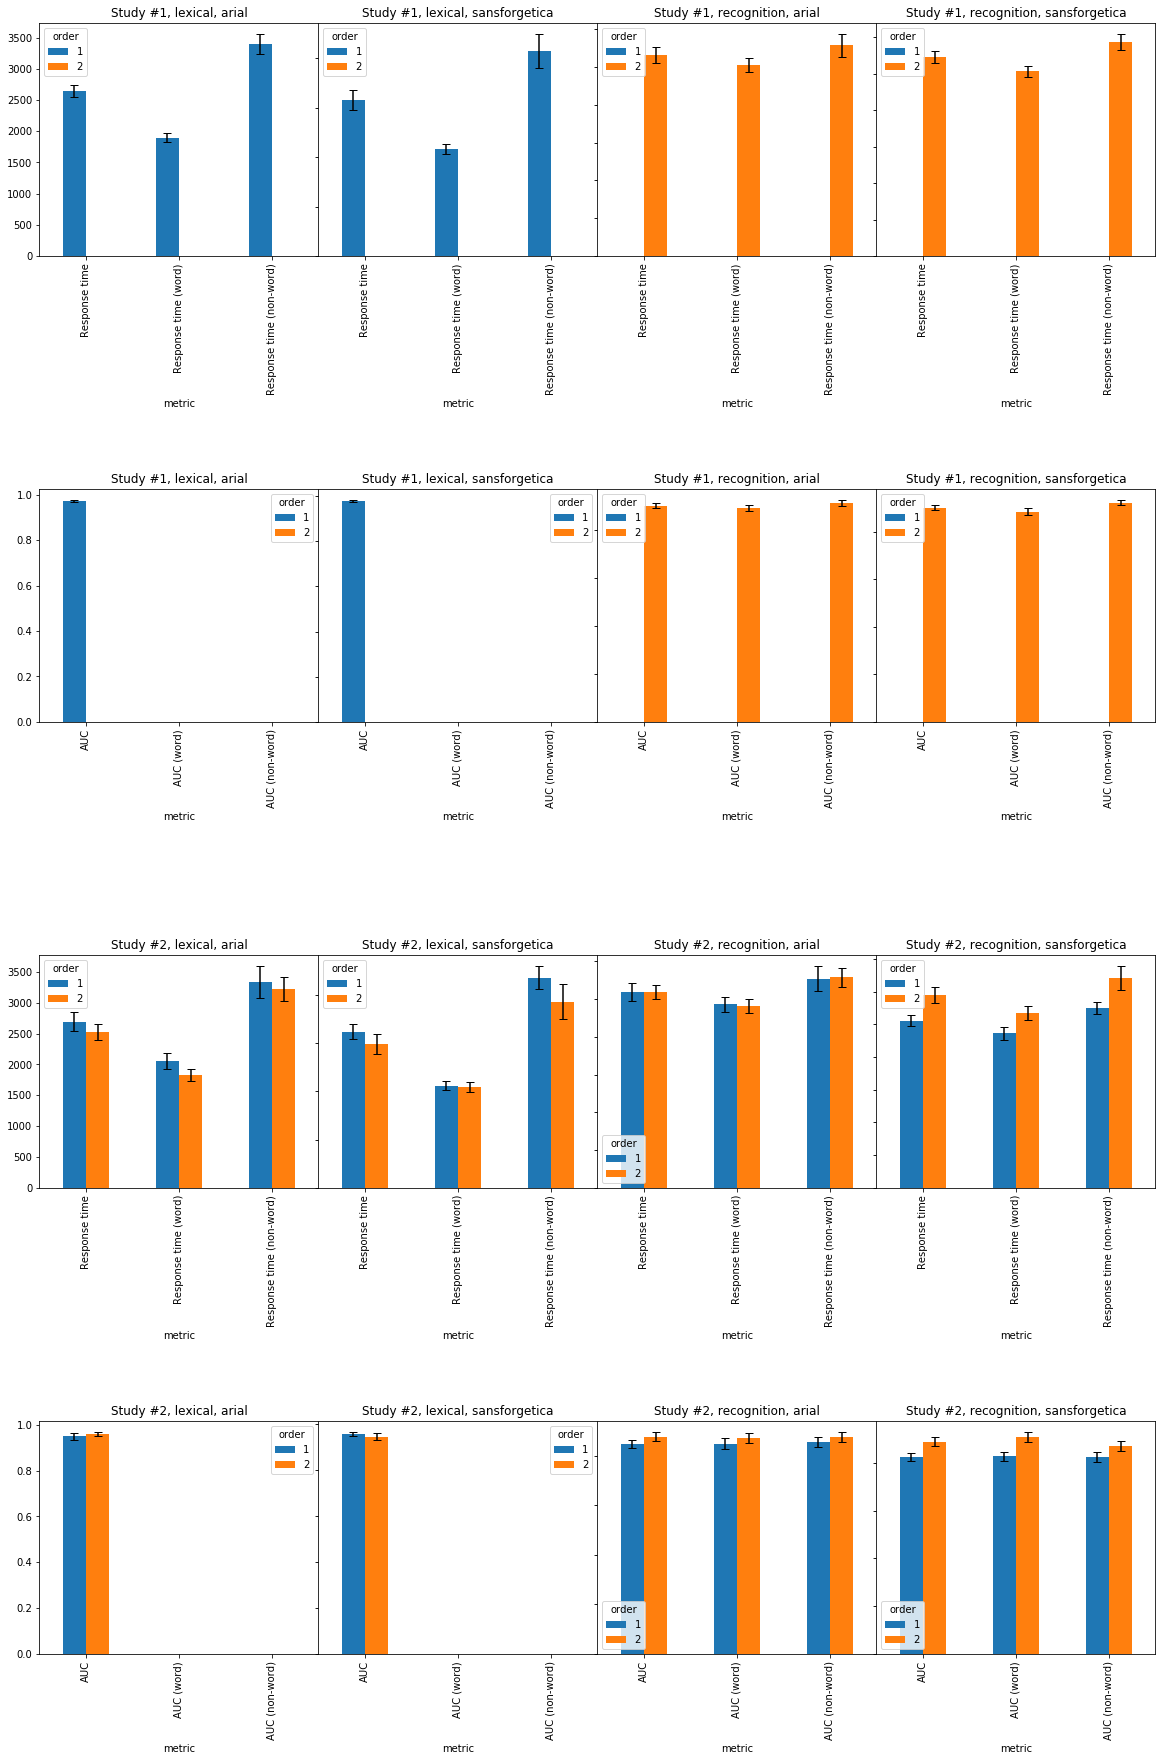

In [33]:
# comparison by order - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % combo)
fig.savefig("results/means-by-order.pdf")

In [34]:
# comparison by order (simpler)

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types], names=["sid", "type"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t in res.index:
    for order in [1, 2]:
        r = st[(st["Order"] == order) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t), (order, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t), (order, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order_simpler.csv")

order                       1                                         \
metric          Response time          Response time (word)            
stat                     mean      SEM                 mean      SEM   
sid type                                                               
1   lexical           2899.93  112.499              2030.32   58.971   
    recognition           NaN      NaN                  NaN      NaN   
2   lexical              2980  113.575              2089.12   79.553   
    recognition       2579.03  69.0412              2395.54  71.2492   

order                                                                    \
metric          Response time (non-word)                AUC               
stat                                mean      SEM      mean         SEM   
sid type                                                                  
1   lexical                      3769.68  192.294  0.974865   0.0033132   
    recognition                      NaN      NaN       NaN         NaN   
2   lexical                      3870.87  182.786  0.953252  0.00830847   
    recognition                  2762.38  94.0704  0.836241   0.0117981   

order                                    ...                        2  \
metric          AUC (word)               ...     Response time (word)   
stat                  mean        SEM    ...                     mean   
sid type                                 ...                            
1   lexical            NaN        NaN    ...                      NaN   
    recognition        NaN        NaN    ...                  2531.92   
2   lexical            NaN        NaN    ...                  1953.78   
    recognition   0.837985  0.0146518    ...                   2535.5   

order                                                                 \
metric                   Response time (non-word)                AUC   
stat                 SEM                     mean      SEM      mean   
sid type                                                               
1   lexical          NaN                      NaN      NaN       NaN   
    recognition  60.9377                  2860.26  92.5757  0.900532   
2   lexical      71.8506                  3528.63  199.167   0.95335   
    recognition  70.8324                   2990.1  109.382  0.883268   

order                                                                         
metric                      AUC (word)             AUC (non-word)             
stat                    SEM       mean         SEM           mean        SEM  
sid type                                                                      
1   lexical             NaN        NaN         NaN            NaN        NaN  
    recognition  0.00744519   0.886598  0.00971855       0.916559  0.0084643  
2   lexical      0.00900626        NaN         NaN            NaN        NaN  
    recognition   0.0125451   0.890777   0.0146652       0.874393  0.0146278  

[4 rows x 24 columns]

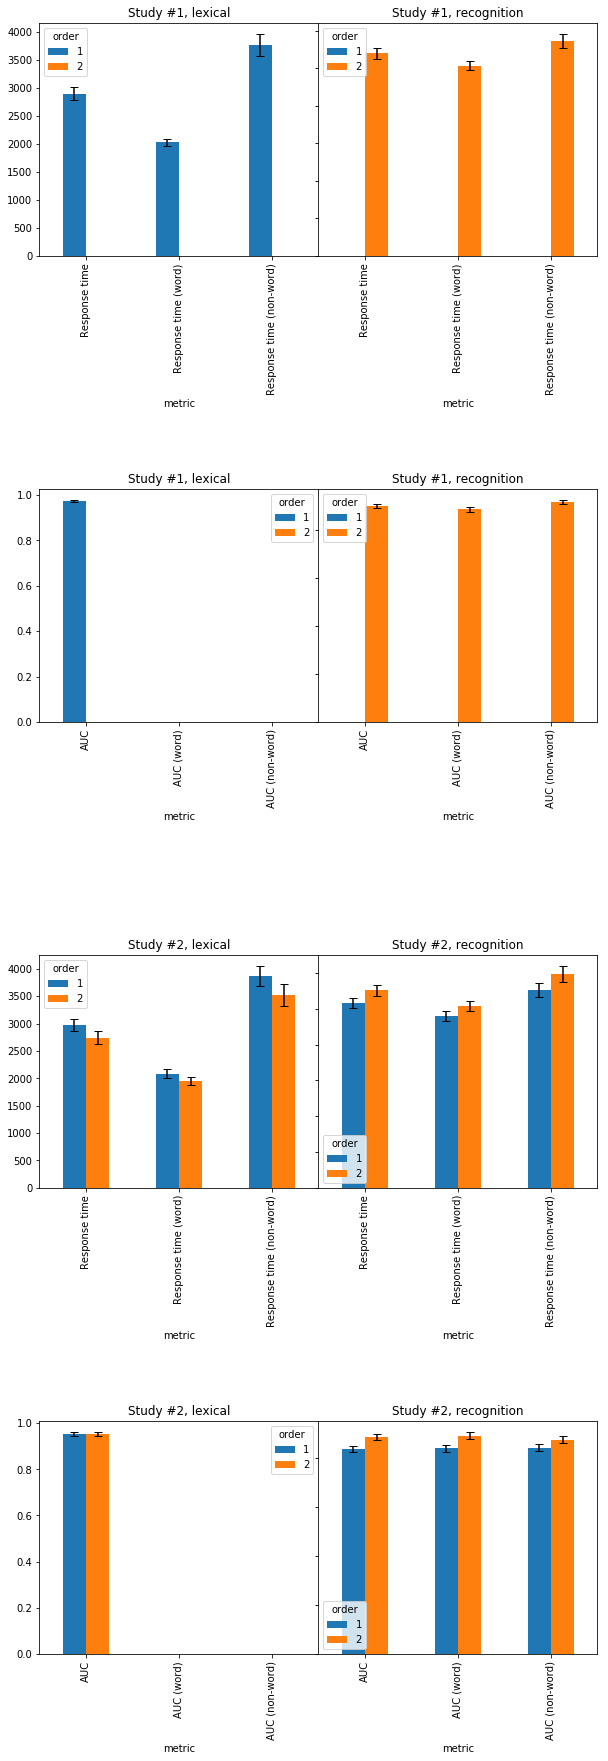

In [35]:
# comparison by order (simpler) - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 2, figsize=(10, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

for sid in [1, 2]:
    for i, t in enumerate(types):
        line = (sid - 1) * 2
        combo = (sid, t)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s" % combo)
fig.savefig("results/means-by-order_simpler.pdf")